# Face Keypoints Detection with Keras

In this notebook, I am going to train a deep learning model to predict face landmarks using [re-annotated LFPW](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/) for training and validation.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os
import math
from pathlib import Path
from os.path import join, exists
from itertools import chain, islice, cycle

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from swissknife.files import FilesStream
from swissknife.utils import calculate_layout
from basedir import LFPW_TRAIN

In [7]:
# Global variables
RANDOM_STATE = 1
NUM_OF_LANDMARKS = 68

Setting a random generator seed helps to get repeatable results in cases when the process of random selection or data shuffling is performed, or in any other algorithm that involves random numbers generation.

In [8]:
np.random.seed(RANDOM_STATE)

## The Dataset

As usual, the data loading and preparation processes are the very first steps in any machine learning pipeline. In our case, we have two arrays of data:
1. Face photos
2. Files with landmarks in PTS format

Therefore, when training the model, our objective will be to iterate through the folder with data, loading images and their landmarks.

### First Glance

Let's now load a couple of data examples to understand how the raw data looks like: 

In [9]:
def read_landmarks(filename, one_based_index=True):
    """
    Reads file in PTS format into two arrays with x and y
    landmarks positions.
    
    The implementation is based on analogous Menpo library function.
    """
    with open(filename) as file:
        lines = [line.strip() for line in file]
        
    line = lines[0]
    while not line.startswith('{'):
        line = lines.pop(0)
        
    xs, ys = [], []
    for line in lines:
        if line.strip().startswith('}'):
            continue
        x, y = line.split()[:2]
        xs.append(x)
        ys.append(y)
        
    offset = 1 if one_based_index else 0
    xs = np.array(xs, dtype=np.float) - offset
    ys = np.array(ys, dtype=np.float) - offset
    return xs, ys

In [10]:
def imread(filename):
    """Reads an image into RGB array format."""
    return cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)

In [11]:
def preview_image_with_landmarks(file_id, dataset=LFPW_TRAIN):
    """
    Shows a single image from the training dataset with face landmarks 
    alongside with its landmarks.
    """
    image_path = join(dataset, f'{file_id}.png')
    pts_path = join(dataset, f'{file_id}.pts')
    assert exists(image_path) and exists(pts_path)
    
    xs, ys = read_landmarks(pts_path)
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.scatter(xs, ys, c='darkorange', s=20, edgecolor='white', alpha=0.8)
    ax.imshow(imread(image_path))
    ax.set_axis_off()
    return fig

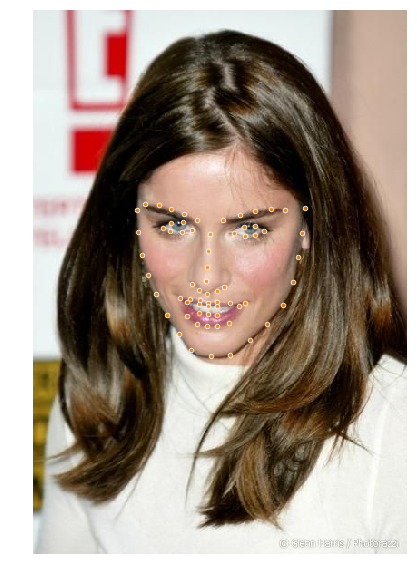

In [12]:
_ = preview_image_with_landmarks('image_0001')

Great, the picture above shows that landmarks reading function correctly reads the landmarks locations, and can be used to parse dataset files. 

Now let's pick a few more images to see if the dataset samples are represented in the same resolution. Also, it would help us to get some understanding of the dataset images quality, illumination, and so forth.

In [13]:
def read_files(root, ext):
    return sorted([
        join(root, filename)
        for filename in os.listdir(root)
        if filename.endswith(f'.{ext}')
    ])

In [14]:
def preview_random_subset_of_images(num_of_samples, n_cols=4, dataset=LFPW_TRAIN):
    """
    Loads a `num_of_samples` images from the dataset and renders them on a single canvas.
    """
    all_images = read_files(dataset, 'png')
    all_points = read_files(dataset, 'pts')
    
    n = len(all_images)
    index = np.random.choice(n, size=num_of_samples)
    
    n_rows, n_cols = calculate_layout(num_of_samples, n_cols=n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()
    
    for ax in axes:
        ax.set_axis_off()

    for idx, ax in zip(index, axes):
        img = imread(all_images[idx])
        xs, ys = read_landmarks(all_points[idx])
        ax.imshow(img)
        ax.scatter(xs, ys, c='darkorange', s=20, edgecolor='white', alpha=0.8)
        ax.set_title(f'shape: {img.shape[0]}x{img.shape[1]}')
    
    return fig

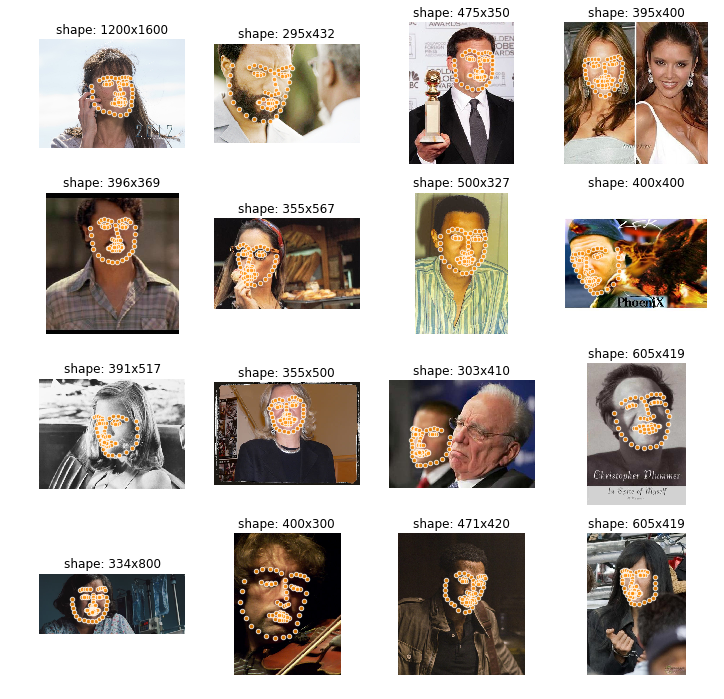

In [15]:
_ = preview_random_subset_of_images(16)

A more thorough investigation shows that the dataset observations are quite different from each other. Some of them even show more then one face! Moreover, the images include a lot of information that is note required to predict face landmarks, like, backgrounds, necks, shoulders, an so on. We only need face rectangles.

Therefore, our next step is to "normalize" the dataset samples to make them ready for a deep model training.

### Images Cropping

It is simple to crop the image from the testing dataset: the positions of landmarks are known in advance and we only need to find a bounding box rectangle using these landmarks points.

In [16]:
def read_single_sample(file_id, dataset=LFPW_TRAIN):
    img = join(dataset, f'{file_id}.png')
    pts = join(dataset, f'{file_id}.pts')
    xs, ys = read_landmarks(pts)
    return imread(img), np.r_[xs, ys]

In [17]:
def split_xy(landmarks):
    n = len(landmarks) // 2
    return landmarks[:n], landmarks[n:]

In [18]:
def crop(image, landmarks, padding=None):
    """
    Crops image to contain only a region of face with landmarks with 
    optional padding region.
    """
    xs, ys = split_xy(landmarks.copy())
    bbox = [xs.min(), ys.min(), xs.max(), ys.max()]
    if padding is not None:
        bbox[0] -= padding
        bbox[1] -= padding
        bbox[2] += padding
        bbox[3] += padding
    left, top, right, bottom = [int(max(0, x)) for x in bbox]
    cropped = image[top:bottom, left:right, :]
    xs -= left
    ys -= top
    new_landmarks = np.r_[xs, ys]
    return cropped, new_landmarks

In [19]:
def show(image, landmarks):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    xs, ys = split_xy(landmarks)
    ax.imshow(image)
    ax.scatter(xs, ys, color='darkorange', edgecolor='white', s=20, alpha=0.8)
    ax.set_axis_off()

In [20]:
img, landmarks = read_single_sample('image_0001')

In [21]:
crop_img, crop_pts = crop(img, landmarks, padding=20)

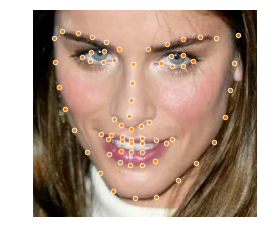

In [22]:
show(crop_img, crop_pts)

Now we have an image that contains a face and its landmarks only. However, in general, each cropped image still has a different resolution. We should implement a function that could rescale the image and its landmarks to some specific shape.

### Rescaling Cropped Images

In [23]:
def resize(image, landmarks, target_size):
    """
    Rescales image and its landmarks without keeping originl aspect ratio.
    """
    image = np.copy(image)
    new_image = cv.resize(image, target_size)
    
    old_h, old_w = image.shape[:2]
    new_h, new_w = new_image.shape[:2]
    w_ratio = new_w / float(old_w)
    h_ratio = new_h / float(old_h)
    n = landmarks.shape[0] // 2
    
    new_landmarks = np.zeros_like(landmarks)
    for i in range(0, n):
        new_landmarks[i] = landmarks[i] * w_ratio
        new_landmarks[i + n] = landmarks[i + n] * h_ratio
    
    return new_image, new_landmarks

In [24]:
def preview_random_subset_of_processed_images(num_of_samples, n_cols=4, dataset=LFPW_TRAIN):
    """
    Loads a `num_of_samples` images from the dataset, applies a set of preprocessing 
    functions and renders the result on a single canvas.
    """
    all_images = read_files(dataset, 'png')
    all_points = read_files(dataset, 'pts')
    
    n = len(all_images)
    index = np.random.choice(n, size=num_of_samples)
    
    n_rows, n_cols = calculate_layout(num_of_samples, n_cols=n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()
    
    for ax in axes:
        ax.set_axis_off()

    for idx, ax in zip(index, axes):
        img = imread(all_images[idx])
        xs, ys = read_landmarks(all_points[idx])
        landmarks = np.r_[xs, ys]
        cropped = crop(img, landmarks, padding=10)
        resized_img, resized_landmarks = resize(*cropped, (120, 120))

        new_xs, new_ys = split_xy(resized_landmarks)
        new_shape = resized_img.shape
        ax.imshow(resized_img)
        ax.scatter(new_xs, new_ys, c='darkorange', s=20, edgecolor='white', alpha=0.8)
        ax.set_title(f'shape: {new_shape[0]}x{new_shape[1]}')
    
    return fig

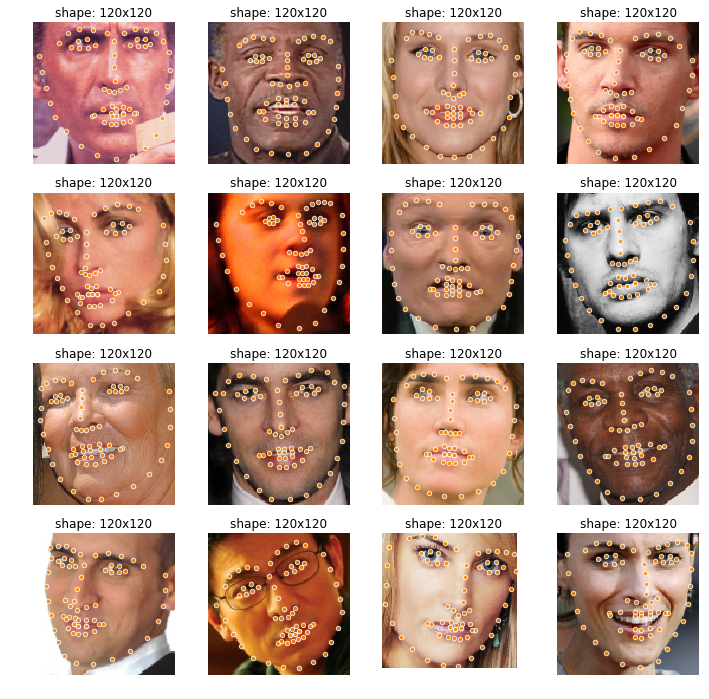

In [25]:
_ = preview_random_subset_of_processed_images(16)

Ok, now we have a an array of the same shape cropped images and ready to start building a deep learning model.

## The Model

We've prepared a set of utilities to transform images but a couple more steps are required to build a high-quality training dataset. We need to join all these scripts into a **data transformation pipeline** that would traverse the folder with the training data, yielding paths to images and landmarks files, read them into `NumPy` arrays, and rescale to an appropriate shapes. 

As soon as we're going to train a deep learning model, it would be a really good idea to apply **data augmentation techniques** to the training images making the model more robust to the noise. Also, probably we don't need color channels to accomplish our goal because face landmarks positions doesn't change if the face is represented as an RGB image or a grayscale one but reducing the number of channels in images will make the training process faster.

Generally speaking, we would like to pass each dataset observation through the following sequence of steps before showing to the model:

1. Crop face regions
2. Resize images to the common shape
3. Convert to grayscale
4. Apply data augmentation operations


### Sanity Checks 

At the very beginning, let's create a utility to verify that data processing steps don't damage our data:

In [26]:
def show_images(images, landmarks, n_cols=4, cmap=None):
    n_rows, n_cols = calculate_layout(len(images), n_cols=n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axes = axes.flatten()

    for ax in axes:
        ax.set_axis_off()
        
    for img, pts, ax in zip(images, landmarks, axes):
        xs, ys = split_xy(pts)
        if img.shape[-1] == 1:
            img = img.reshape(img.shape[0], img.shape[1])
            cmap = 'gray'
        ax.imshow(img, cmap=cmap)
        ax.set_title(img.shape)
        ax.scatter(xs, ys, color='darkorange', edgecolor='white', s=20)

### Reading Files in Batches

A deep learning model training is usually performed using batch optimization algorithms: we don't show all the data at once but split the dataset into smaller chunks. The `AnnotatedImagesStream` class is intended to read images and their landmarks from a hard drive and yield them in batches to the caller.

In [27]:
class AnnotatedImagesStream:
    """
    Yields batches of image and annotation files from a dataset root folder.
    """
    def __init__(self,
                 root: str,
                 batch_size: int=32,
                 infinite: bool=False,
                 same_size_batches: bool=False,
                 images_ext: str='jpg|jpeg|png',
                 points_ext: str='pts'):

        self.root = root
        self.batch_size = batch_size
        self.infinite = infinite
        self.same_size_batches = same_size_batches
        self.images_files = glob_extensions(self.root, images_ext)
        self.points_files = glob_extensions(self.root, points_ext)

        if not infinite and same_size_batches:
            raise ValueError('Incompatible configuration: cannot guarantee '
                             'same size of batches when yielding finite '
                             'number of files.')

        pairs = list(zip(self.images_files, self.points_files))
        for img_name, pts_name in pairs:
            assert Path(img_name).stem == Path(pts_name).stem

        n_files = len(pairs)
        if same_size_batches:
            n_batches = n_files // batch_size
        else:
            n_batches = int(math.ceil(n_files / batch_size))

        self._n_batches = n_batches
        self._iter = cycle(pairs) if infinite else iter(pairs)
        self._count = 0

    @property
    def n_batches(self):
        return self._n_batches

    def __iter__(self):
        return self

    def __next__(self):
        if not self.infinite and self._count >= self._n_batches:
            raise StopIteration()
        item = self.next()
        self._count += 1
        return item

    def next(self):
        bs = self.batch_size
        if self.infinite and self._count == self._n_batches:
            self._iter = iter(list(zip(self.images_files, self.points_files)))
            self._count = 0
        x_batch, y_batch = zip(*[xy for xy in islice(self._iter, 0, bs)])
        return x_batch, y_batch


def glob_extensions(folder, extensions):
    folder = Path(folder)
    return sorted([
        path.as_posix()
        for path in chain(*[
            folder.glob('*.' + ext)
            for ext in parse_extensions(extensions)])])


def parse_extensions(string):
    return string.split('|') if '|' in string else [string]

Next, we need to convert the filenames into `NumPy` arrays:

In [28]:
class FilesReader:
    
    def __init__(self, target_size, padding):
        self.target_size = target_size
        self.padding = padding
        
    def __call__(self, x_batch, y_batch):
        images, landmarks = [], []
        for img_file, pts_file in zip(x_batch, y_batch):
            img = imread(img_file)
            xs, ys = read_landmarks(pts_file)
            pts = np.r_[xs, ys]
            cropped = crop(img, pts, padding=self.padding)
            new_img, new_pts = resize(*cropped, target_size=self.target_size)
            images.append(new_img)
            landmarks.append(new_pts)
        return np.array(images), np.array(landmarks)

In [29]:
def to_grayscale(x_batch, y_batch):
    """
    We ignore landmarks because their positions are not affected by 
    converting image into another color space.
    """
    n, w, h = x_batch.shape[:3]
    grayscaled = np.zeros((n, w, h, 1))
    for i, image in enumerate(x_batch):
        new_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        grayscaled[i, :] = new_image.reshape((w, h, 1))
    return grayscaled, y_batch

Let's check if our classes works as expected and convert file names into numerical arrays with predefiened shapes:

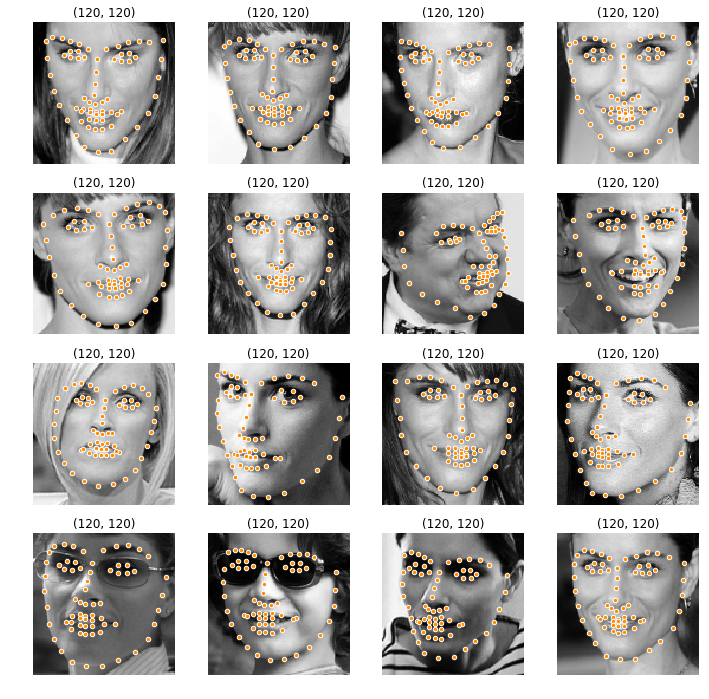

In [30]:
stream = AnnotatedImagesStream(root=LFPW_TRAIN, batch_size=16)
reader = FilesReader(target_size=(120, 120), padding=20)
x_batch, y_batch = next(stream)
img, pts = to_grayscale(*reader(x_batch, y_batch))
show_images(img, pts)

### Data Augmentation

In [31]:
class RandomAugmentationMixin:
    
    def __init__(self, probability=0.5):
        self.probability = probability
        
    def apply(self, image, landmarks):
        if np.random.rand() > self.probability:
            new_image, new_landmarks = image.copy(), landmarks.copy()
            return self._apply(new_image, new_landmarks)
        else:
            return image, landmarks
        
    def _apply(self, image, landmarks):
        raise NotImplementedError()

In [32]:
class AffineTransformation(RandomAugmentationMixin):
    
    def __init__(self, matrix, **kwargs):
        super().__init__(**kwargs)
        assert matrix.shape == (2, 3)
        self.matrix = matrix
        
    @property
    def rotation(self):
        return self.matrix[:2, :2]
    
    @property
    def shift(self):
        return self.matrix[:, -1].reshape(-1, 1)
        
    def _apply(self, image, landmarks):
        cols, rows = image.shape[:2]
        new_image = cv.warpAffine(image, self.matrix, (rows, cols))
        n = len(landmarks) // 2
        xy = landmarks.reshape(-1, n)
        xy_transformed = self.rotation @ xy + self.shift
        new_landmarks = xy_transformed.flatten()
        return new_image, new_landmarks

In [33]:
class Rotation(AffineTransformation):
    
    def __init__(self, center, angle_range=(-10, 10), probability=0.5):
        angle = np.random.uniform(*angle_range)
        matrix = cv.getRotationMatrix2D(center, angle, 1)
        super().__init__(matrix)

In [34]:
class Shift(AffineTransformation):
    
    def __init__(self, shift_range=(-5, 5), shift_x=True, shift_y=True):
        shifts = np.array([0, 0])
        if shift_x:
            shifts[0] = np.random.uniform(*shift_range)
        if shift_y:
            shifts[1] = np.random.uniform(*shift_range)
        rotation = np.eye(2)
        matrix = np.c_[rotation, shifts.reshape(-1, 1)]
        super().__init__(matrix)

In [35]:
class HorizontalFlip(RandomAugmentationMixin):
    
    def _apply(self, image, landmarks):
        new_image = cv.flip(image, 1)
        new_landmarks = landmarks.copy()
        n = image.shape[0]
        half = n // 2        
        new_landmarks[0:half] = n - landmarks[0:half]
        new_landmarks[half:n] = landmarks[half:n]
        return new_image, new_landmarks

> **Note:** The gamma correction below is based on this [SO question](https://stackoverflow.com/questions/33322488/how-to-change-image-illumination-in-opencv-python).

In [36]:
class GammaCorrection(RandomAugmentationMixin):
    
    def __init__(self, gamma_range=[0.5, 1.5], **kwargs):
        super().__init__(**kwargs)
        min_gamma, max_gamma = gamma_range
        delta = max_gamma - min_gamma
        self.gamma = delta * np.random.rand() + min_gamma
        
    def _apply(self, image, landmarks):
        inv_gamma = 1.0 / self.gamma
        table = np.array([
            255 * ((i / 255.0) ** inv_gamma) 
            for i in np.arange(0, 256)])
        new_image = cv.LUT(image.astype(np.uint8), table.astype(np.uint8))
        return new_image, landmarks

In [41]:
class AugmentationsList:
    
    def __init__(self, augmentations):
        self.augmentations = augmentations
        for aug in self.augmentations:
            assert hasattr(aug, 'apply')
    
    def apply(self, image, landmarks):
        old_shape = image.shape
        sample = image, landmarks
        for aug in self.augmentations:
            sample = aug.apply(*sample)
        new_image, new_landmarks = sample
        return new_image.reshape(old_shape), new_landmarks
    
    def apply_to_batch(self, x_batch, y_batch):
        new_x_batch = np.zeros_like(x_batch)
        new_y_batch = np.zeros_like(y_batch)
        
        for i, (x, y) in enumerate(zip(x_batch, y_batch)):
            new_x, new_y = self.apply(x, y)
            new_x_batch[i] = new_x
            new_y_batch[i] = new_y
        
        return new_x_batch, new_y_batch

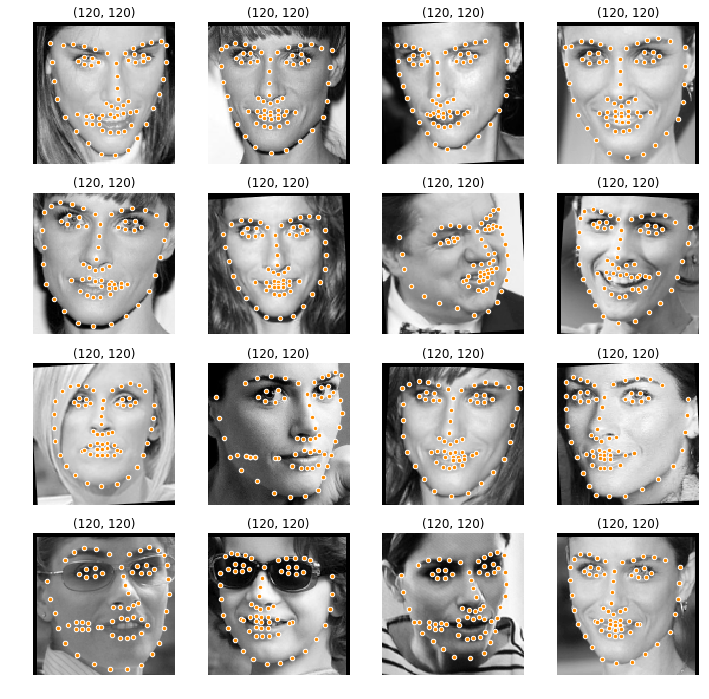

In [42]:
stream = AnnotatedImagesStream(root=LFPW_TRAIN, batch_size=16)
reader = FilesReader(target_size=(120, 120), padding=20)

rotation = Rotation(center=(60, 60))
shift = Shift(shift_range=(-10, 10))
flip = HorizontalFlip()
gamma = GammaCorrection()
augmentation = AugmentationsList([rotation, shift, flip, gamma])

x_batch, y_batch = to_grayscale(*reader(*next(stream)))
images, points = augmentation.apply_to_batch(x_batch, y_batch)

show_images(images, points)   

In [ ]:
def preprocess_training_batch():
    

In [44]:
%ls /home/ck/data/landmarks/lfpw/testset/

image_0001.png  image_0051.png  image_0099.png  image_0148.png  image_0196.png
image_0001.pts  image_0051.pts  image_0099.pts  image_0148.pts  image_0196.pts
image_0002.png  image_0052.png  image_0100.png  image_0149.png  image_0197.png
image_0002.pts  image_0052.pts  image_0100.pts  image_0149.pts  image_0197.pts
image_0003.png  image_0053.png  image_0101.png  image_0150.png  image_0198.png
image_0003.pts  image_0053.pts  image_0101.pts  image_0150.pts  image_0198.pts
image_0004.png  image_0054.png  image_0102.png  image_0151.png  image_0199.png
image_0004.pts  image_0054.pts  image_0102.pts  image_0151.pts  image_0199.pts
image_0005.png  image_0055.png  image_0103.png  image_0152.png  image_0200.png
image_0005.pts  image_0055.pts  image_0103.pts  image_0152.pts  image_0200.pts
image_0006.png  image_0056.png  image_0104.png  image_0153.png  image_0201.png
image_0006.pts  image_0056.pts  image_0104.pts  image_0153.pts  image_0201.pts
image_0007.png  image_0057.png  image_0105.png  imag